**Estimating mean and standard deviation of normal distribution**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm2
import pymc3 as pm3
import scipy.stats as stats

np.random.seed(1234)
plt.style.use('ggplot')

# plots don't show on notebook unless use this
%matplotlib inline

In [2]:
# generate data
num_obs = 100
mu_true = 10
sigma_true = 2 # tau = 1/sigma^2 so tau_true = 0.25
vy = stats.norm(mu_true, sigma_true).rvs(num_obs)

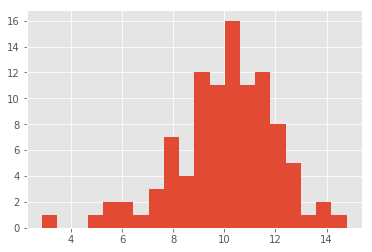

In [3]:
# plot data
plt.hist(vy, bins=20);  # semicolon suppresses non-graphical output
# plt.show()

# PyMC2

In [4]:
# define model
mu_ = pm2.Uniform('mu', lower=0, upper=100)
tau_ = pm2.Uniform('tau', lower=0, upper=1)
y_ = pm2.Normal('Y_obs', mu=mu_, tau=tau_, value=vy, observed=True)
mod = pm2.Model([mu_, tau_])

In [5]:
# map estimates of variables, could be used as starting values for sampler
mapper = pm2.MAP(mod)
mapper.fit()
for x in mod.variables:
    print(x, "=",  x.value)

mu = 10.070224566250877
tau = 0.2521675438274839


In [6]:
# sample model
sampler = pm2.MCMC(mod)
sampler.sample(iter=11000, burn=10000)

 [-----------------100%-----------------] 11000 of 11000 complete in 1.8 sec

Plotting mu
Plotting tau


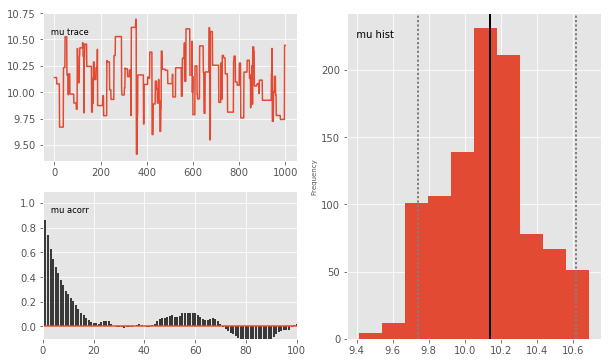

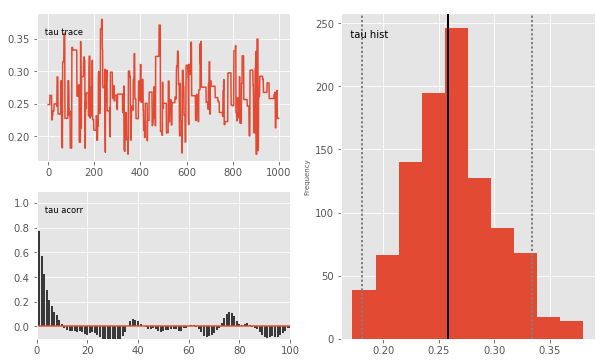

In [7]:
# analysis of samples
pm2.Matplot.plot(sampler, path='pymc2_plots')

In [8]:
for x in mod.variables:
    x.summary()


mu:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	10.117           0.246            0.02           [  9.741  10.615]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	9.669            9.924           10.139         10.256        10.612
	

tau:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.262            0.04             0.003            [ 0.181  0.334]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.182            0.235           0.259          0.285         0.346
	


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [9]:
%%bash
rm -rf pymc2_plots

# PyMC3

In [10]:
# define model
basic_model = pm3.Model()

with basic_model:
    mu_ = pm3.Uniform('mu', lower=0, upper=100)
    tau_ = pm3.Uniform('tau', lower=0, upper=1)
    y_ = pm3.Normal('y', mu=mu_, tau=tau_, observed=vy)

In [11]:
# MAP estimates
map_vals = pm3.find_MAP(model=basic_model)
print(map_vals)

Optimization terminated successfully.
         Current function value: 214.841591
         Iterations: 11
         Function evaluations: 33
         Gradient evaluations: 33
{'mu_interval_': array(-2.189065157879638), 'tau_interval_': array(-1.0695765889199584)}


In [12]:
# sample model
chain_length = 10000 

with basic_model:
    start_vals = map_vals
    # instantiate sampler
    step = pm3.Metropolis() 
    trace = pm3.sample(chain_length, step=step, start=start_vals) 

100%|██████████| 10000/10000 [00:04<00:00, 2352.39it/s]


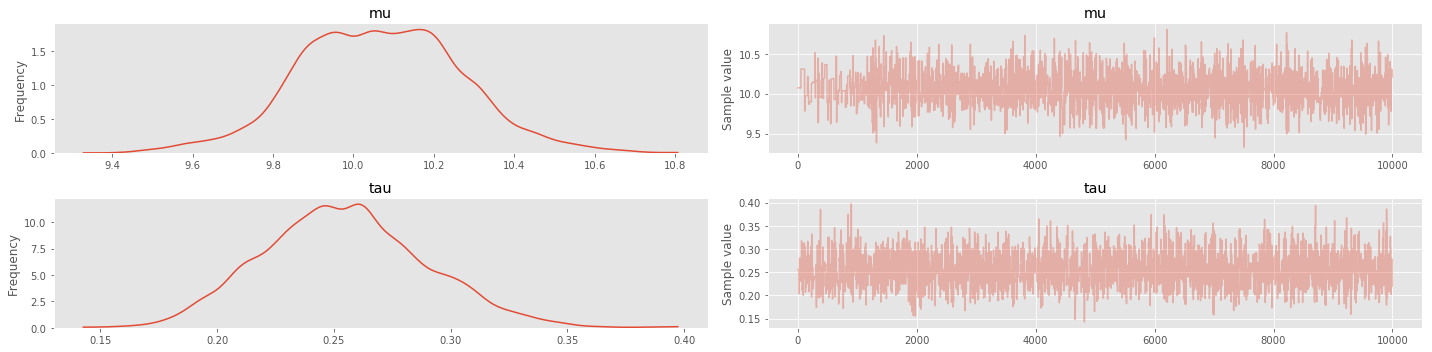

In [13]:
# analysis of samples
pm3.traceplot(trace,figsize=(20,5));

In [14]:
pm3.summary(trace)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.067           0.202            0.004            [9.667, 10.469]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9.664          9.927          10.064         10.202         10.469


tau:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.255            0.035            0.001            [0.189, 0.323]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.192          0.230          0.253          0.277          0.327



In [15]:
trace.varnames

['mu_interval_', 'tau_interval_', 'mu', 'tau']

In [16]:
trace['mu']

array([ 10.07367482,  10.07367482,  10.07367482, ...,  10.20950845,
        10.20950845,  10.20950845])

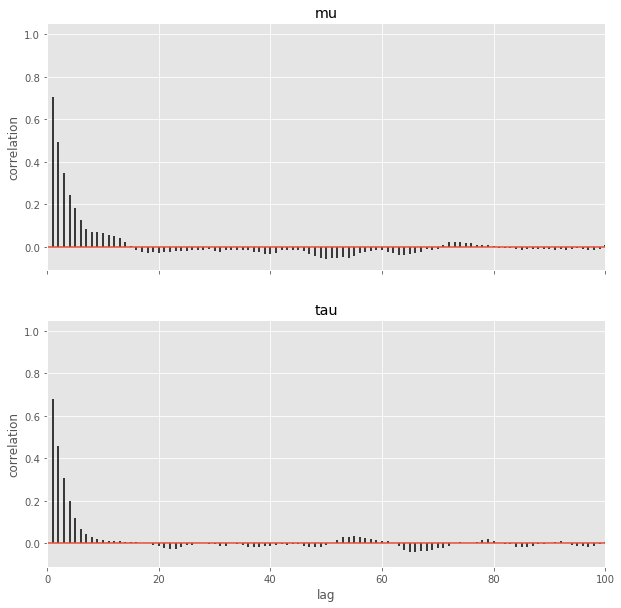

In [17]:
pm3.plots.autocorrplot(trace, figsize=(10,10));

In [18]:
# sample model, multiple njobs
chain_length = 10000

with basic_model:
    # obtain starting values via MAP
    startvals = pm3.find_MAP(model=basic_model)
    print(startvals) 
    # instantiate sampler
    step = pm3.Metropolis() 

    trace = pm3.sample(chain_length, step=step, start=startvals, njobs=4)

Optimization terminated successfully.
         Current function value: 214.841591
         Iterations: 11
         Function evaluations: 33
         Gradient evaluations: 33
{'mu_interval_': array(-2.189065157879638), 'tau_interval_': array(-1.0695765889199584)}


100%|██████████| 10000/10000 [00:19<00:00, 519.45it/s]

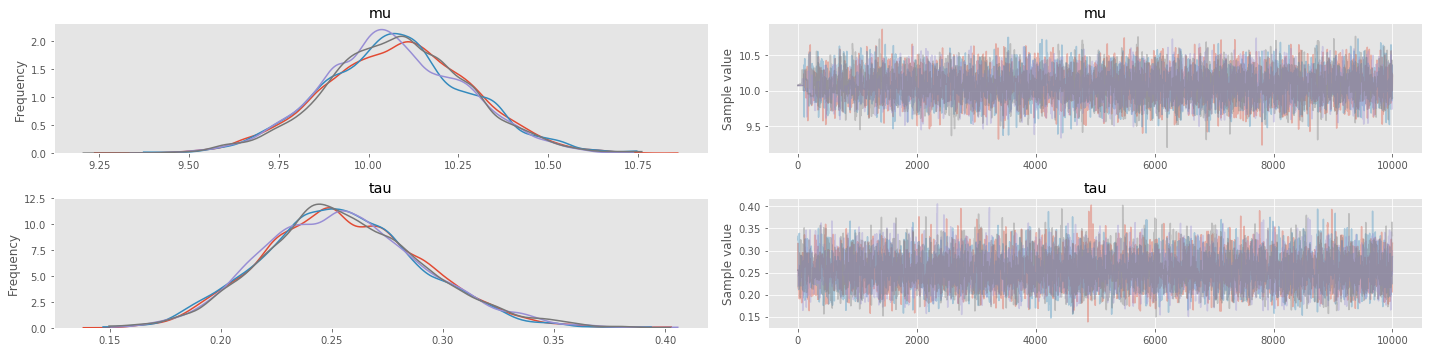

In [19]:
pm3.traceplot(trace,figsize=(20,5));

In [20]:
pm3.gelman_rubin(trace)

{'mu': 1.0002702547982412,
 'mu_interval_': 1.0002639777570221,
 'tau': 1.0002472249474545,
 'tau_interval_': 1.0002335333287895}